In [34]:
!pip install datasets transformers nltk evaluate tqdm

In [35]:
from tqdm import tqdm
import sys
import os
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("blue_score.ipynb"), "..")))
from datasets import load_dataset

# from transformers_models.marian.marianMT import


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:

def retrieve_data():
    dataset = load_dataset("wmt14", "de-en")

    subset = dataset["train"].select(range(120000))

    # train_data = subset.select(range(100000))
    # val_data = subset.select(range(100000, 110000))
    # test_data = subset.select(range(110000, 120000))



    train_data = subset.select(range(10000))
    val_data = subset.select(range(10000, 11000))
    test_data = subset.select(range(10000, 12000))
    return {
        "train": train_data,
        "validation": val_data,
        "test": test_data
    }


In [37]:
def translated(n, model):
    return model.translate_text(n)

In [38]:

data = retrieve_data()


In [39]:
data["validation"]["translation"]

[{'de': '.', 'en': '.'},
 {'de': '(DA) Das Projekt Europa begann als Zusammenarbeit zwischen Staaten.',
  'en': '(DA) The European project began as a partnership between States.'},
 {'de': 'Diese Zusammenarbeit war 50 Jahre lang eine Garantie für Frieden und Stabilität in unserem Teil Europas.',
  'en': 'This partnership has ensured peace and stability in our part of Europe for over 50 years.'},
 {'de': 'Als Folge der wirtschaftlichen und politischen Erfolge in unserem Teil der Welt, für den u. a. die EU ein Beispiel ist, und aufgrund der zunehmenden Verbreitung unserer westlichen Werte hat der Wettbewerb auf dem Weltmarkt in den letzten Jahrzehnten stark zugenommen.',
  'en': 'As a result of the economic and political success in our part of the world, of which the EU is just one proof, and in view of the ever greater proliferation of our Western values, competition on the world market has grown considerably within the last few decades.'},
 {'de': 'Auf diesen Wettbewerb muß sich die EU

In [40]:
data["test"]["translation"]

[{'de': '.', 'en': '.'},
 {'de': '(DA) Das Projekt Europa begann als Zusammenarbeit zwischen Staaten.',
  'en': '(DA) The European project began as a partnership between States.'},
 {'de': 'Diese Zusammenarbeit war 50 Jahre lang eine Garantie für Frieden und Stabilität in unserem Teil Europas.',
  'en': 'This partnership has ensured peace and stability in our part of Europe for over 50 years.'},
 {'de': 'Als Folge der wirtschaftlichen und politischen Erfolge in unserem Teil der Welt, für den u. a. die EU ein Beispiel ist, und aufgrund der zunehmenden Verbreitung unserer westlichen Werte hat der Wettbewerb auf dem Weltmarkt in den letzten Jahrzehnten stark zugenommen.',
  'en': 'As a result of the economic and political success in our part of the world, of which the EU is just one proof, and in view of the ever greater proliferation of our Western values, competition on the world market has grown considerably within the last few decades.'},
 {'de': 'Auf diesen Wettbewerb muß sich die EU

In [41]:
data["train"]["translation"]

[{'de': 'Wiederaufnahme der Sitzungsperiode',
  'en': 'Resumption of the session'},
 {'de': 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.',
  'en': 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.'},
 {'de': 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.',
  'en': "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."},
 {'de': 'Im Parlament besteht der Wunsch nach einer Aussprache im

In [42]:
from transformers import MarianMTModel, MarianTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [43]:
english = [n["en"] for n in data["train"]["translation"]]
german = [n["de"] for n in data["train"]["translation"]]

In [44]:
# translation_pairs_en2de = {"en":[], "de":[]}


# for pair in data["train"]["translation"]:
#     translation_pairs_en2de["en"].append(pair["en"])
#     translation_pairs_en2de["de"].append(pair["de"])

In [45]:
# translation_pairs_en2de

In [46]:
# translation_pairs_en2de_input_output = [
#     {"en": src, "de": tgt}
#     for src, tgt in zip(translation_pairs_en2de["en"], translation_pairs_en2de["de"])
# ]

In [47]:
data

{'train': Dataset({
     features: ['translation'],
     num_rows: 10000
 }),
 'validation': Dataset({
     features: ['translation'],
     num_rows: 1000
 }),
 'test': Dataset({
     features: ['translation'],
     num_rows: 2000
 })}

In [48]:
def preprocess(batch):
    inputs = tokenizer(
        batch["translation"]["en"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(
            batch["translation"]["de"],
            truncation=True,
            padding="max_length",
            max_length=128
        )
    inputs["labels"] = targets["input_ids"]
    return inputs


In [49]:
tokenized_data = {
    "train": data["train"].map(preprocess),
    "validation": data["validation"].map(preprocess)
}


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [50]:
from tqdm import tqdm
import evaluate

bleu = evaluate.load("bleu")
test_subset = data["test"].select(range(1000))

src_texts = [ex["translation"]["en"] for ex in test_subset]
references = [[ex["translation"]["de"]] for ex in test_subset]

batch_size = 16
predictions = []

for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
    batch = src_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=128)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(preds)


Translating: 100%|██████████| 63/63 [24:38<00:00, 23.46s/it]


In [51]:
results = bleu.compute(predictions=predictions, references=references)
print(f"BLEU before fine-tunning score: {results['bleu']:.4f}")



BLEU score: 0.1637


In [52]:
results

{'bleu': 0.16373598822160015,
 'precisions': [0.38634263034850214,
  0.20007824288828033,
  0.12079224997844022,
  0.07697771464085945],
 'brevity_penalty': 1.0,
 'length_ratio': 1.4088854844887015,
 'translation_length': 36786,
 'reference_length': 26110}

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [54]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./marianmt-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=5,
    save_strategy="epoch",
    predict_with_generate=True,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [55]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [56]:
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
)

trainer.train()


<ipython-input-56-52aa931319c5>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
500,0.472100
1000,0.405700
1500,0.410600
2000,0.401000
2500,0.404500
3000,0.288200
3500,0.299600
4000,0.301700
4500,0.301600
5000,0.299500


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=12500, training_loss=0.2575603161621094, metrics={'train_runtime': 1243.5859, 'train_samples_per_second': 40.206, 'train_steps_per_second': 10.052, 'total_flos': 1694918246400000.0, 'train_loss': 0.2575603161621094, 'epoch': 5.0})

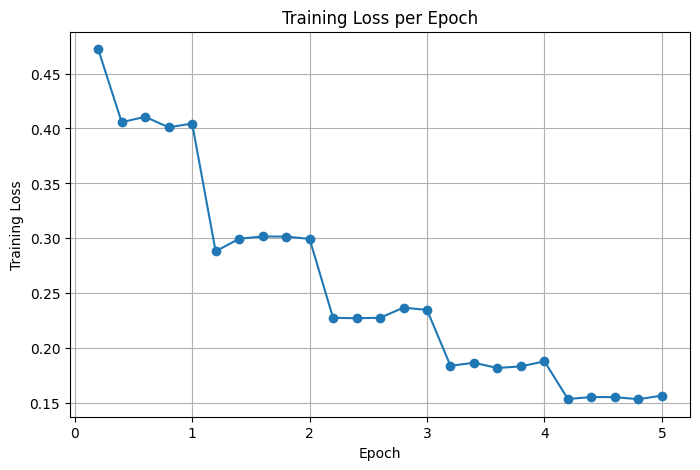

In [57]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
steps = []
losses = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        steps.append(entry["epoch"])
        losses.append(entry["loss"])

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()


In [58]:
bleu = evaluate.load("bleu")
test_subset = data["test"].select(range(1000))

src_texts = [ex["translation"]["en"] for ex in test_subset]
references = [[ex["translation"]["de"]] for ex in test_subset]

batch_size = 16
predictions = []

for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
    batch = src_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=128)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(preds)

Translating: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


In [59]:
results = bleu.compute(predictions=predictions, references=references)
print(f"BLEU score after fine-tuning: {results['bleu']:.4f}")

BLEU score after fine-tuning: 0.2178


In [60]:
model.save_pretrained("marianmt-finetuned")
tokenizer.save_pretrained("marianmt-finetuned")


('marianmt-finetuned/tokenizer_config.json',
 'marianmt-finetuned/special_tokens_map.json',
 'marianmt-finetuned/vocab.json',
 'marianmt-finetuned/source.spm',
 'marianmt-finetuned/target.spm',
 'marianmt-finetuned/added_tokens.json')